In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
!pip install -qr requirements.txt  # install

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5


In [ ]:
!pip install -q roboflow

In [ ]:
import torch

from IPython.display import Image, clear_output
from utils.downloads import attempt_download
from roboflow import Roboflow

Setup complete. Using torch 2.1.0+cu118 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


/content/datasets


In [ ]:
rf = Roboflow(api_key="flQynYGkEPQqsJ2hMfHG")
project = rf.workspace("ithb-5ka4m").project("lisa-traffic-light-detection-8vuch")
dataset = project.version(3).download("yolov5")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to LISA-traffic-light-detection-3 in yolov5pytorch:: 100%|██████████| 17882/17882 [00:03<00:00, 5847.45it/s]


In [ ]:
%cat {dataset.location}/data.yaml

names:
- go
- stop
- warning
nc: 3
roboflow:
  license: CC BY 4.0
  project: lisa-traffic-light-detection-8vuch
  url: https://universe.roboflow.com/ithb-5ka4m/lisa-traffic-light-detection-8vuch/dataset/3
  version: 3
  workspace: ithb-5ka4m
test: ../test/images
train: LISA-traffic-light-detection-3/train/images
val: LISA-traffic-light-detection-3/valid/images


In [ ]:
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]

In [ ]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]


In [ ]:
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 25 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache


/content/yolov5
WARNING ⚠️ Ultralytics settings reset to default values. This may be due to a possible problem with your settings or a recent ultralytics package update. 
View settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.yaml'
Update settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'.
2023-11-26 08:32:49.831197: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-26 08:32:49.831261: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-26 08:32:49.831307: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=, 

## Validate

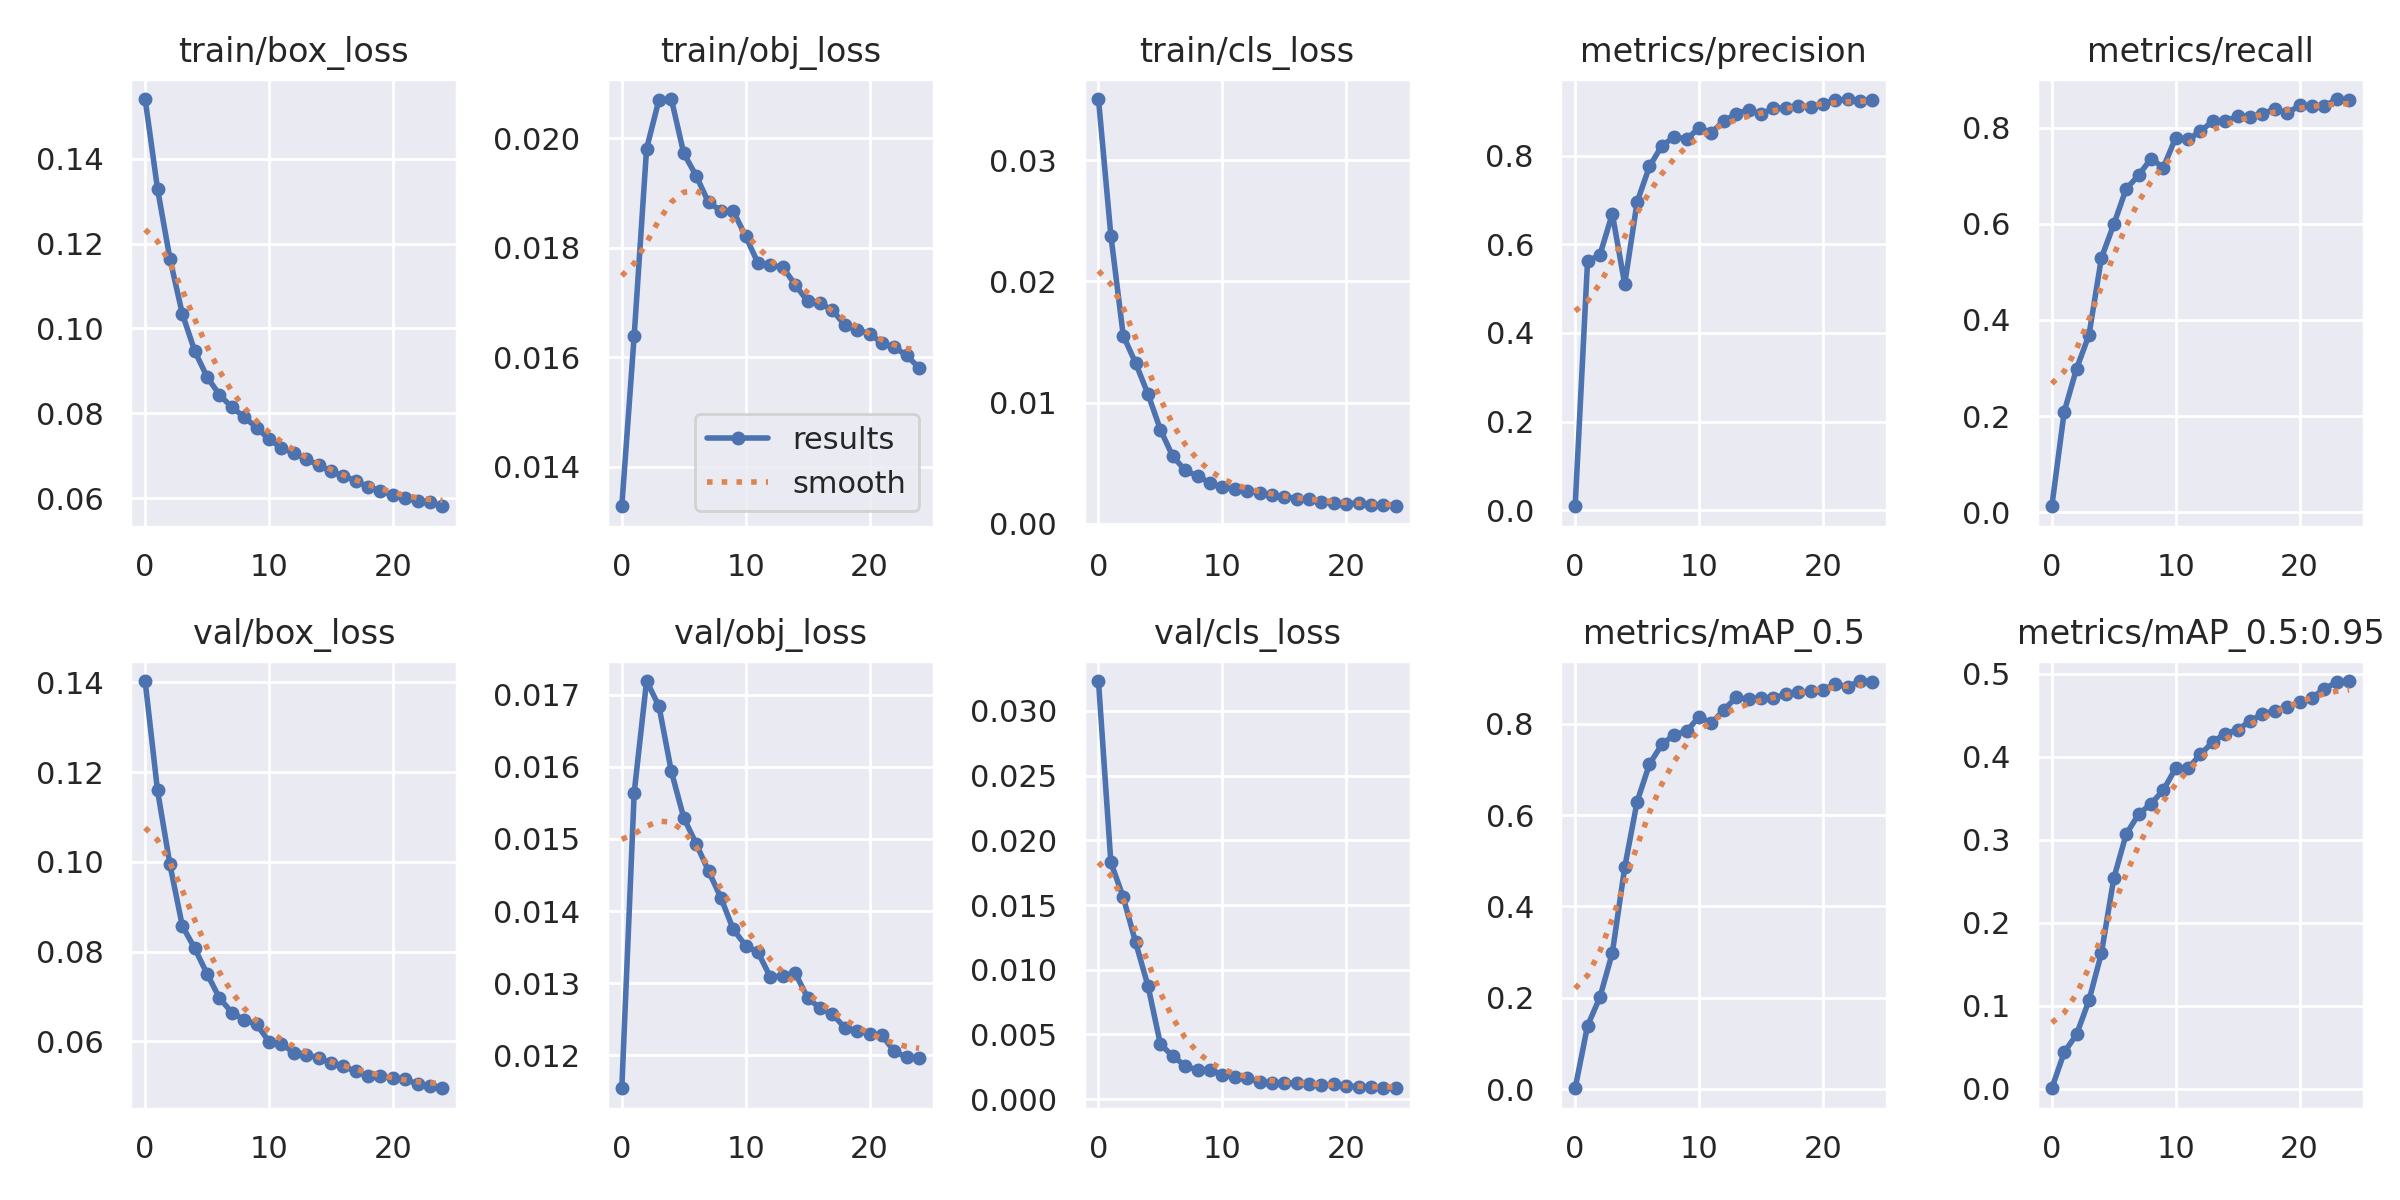

In [ ]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

## Inference

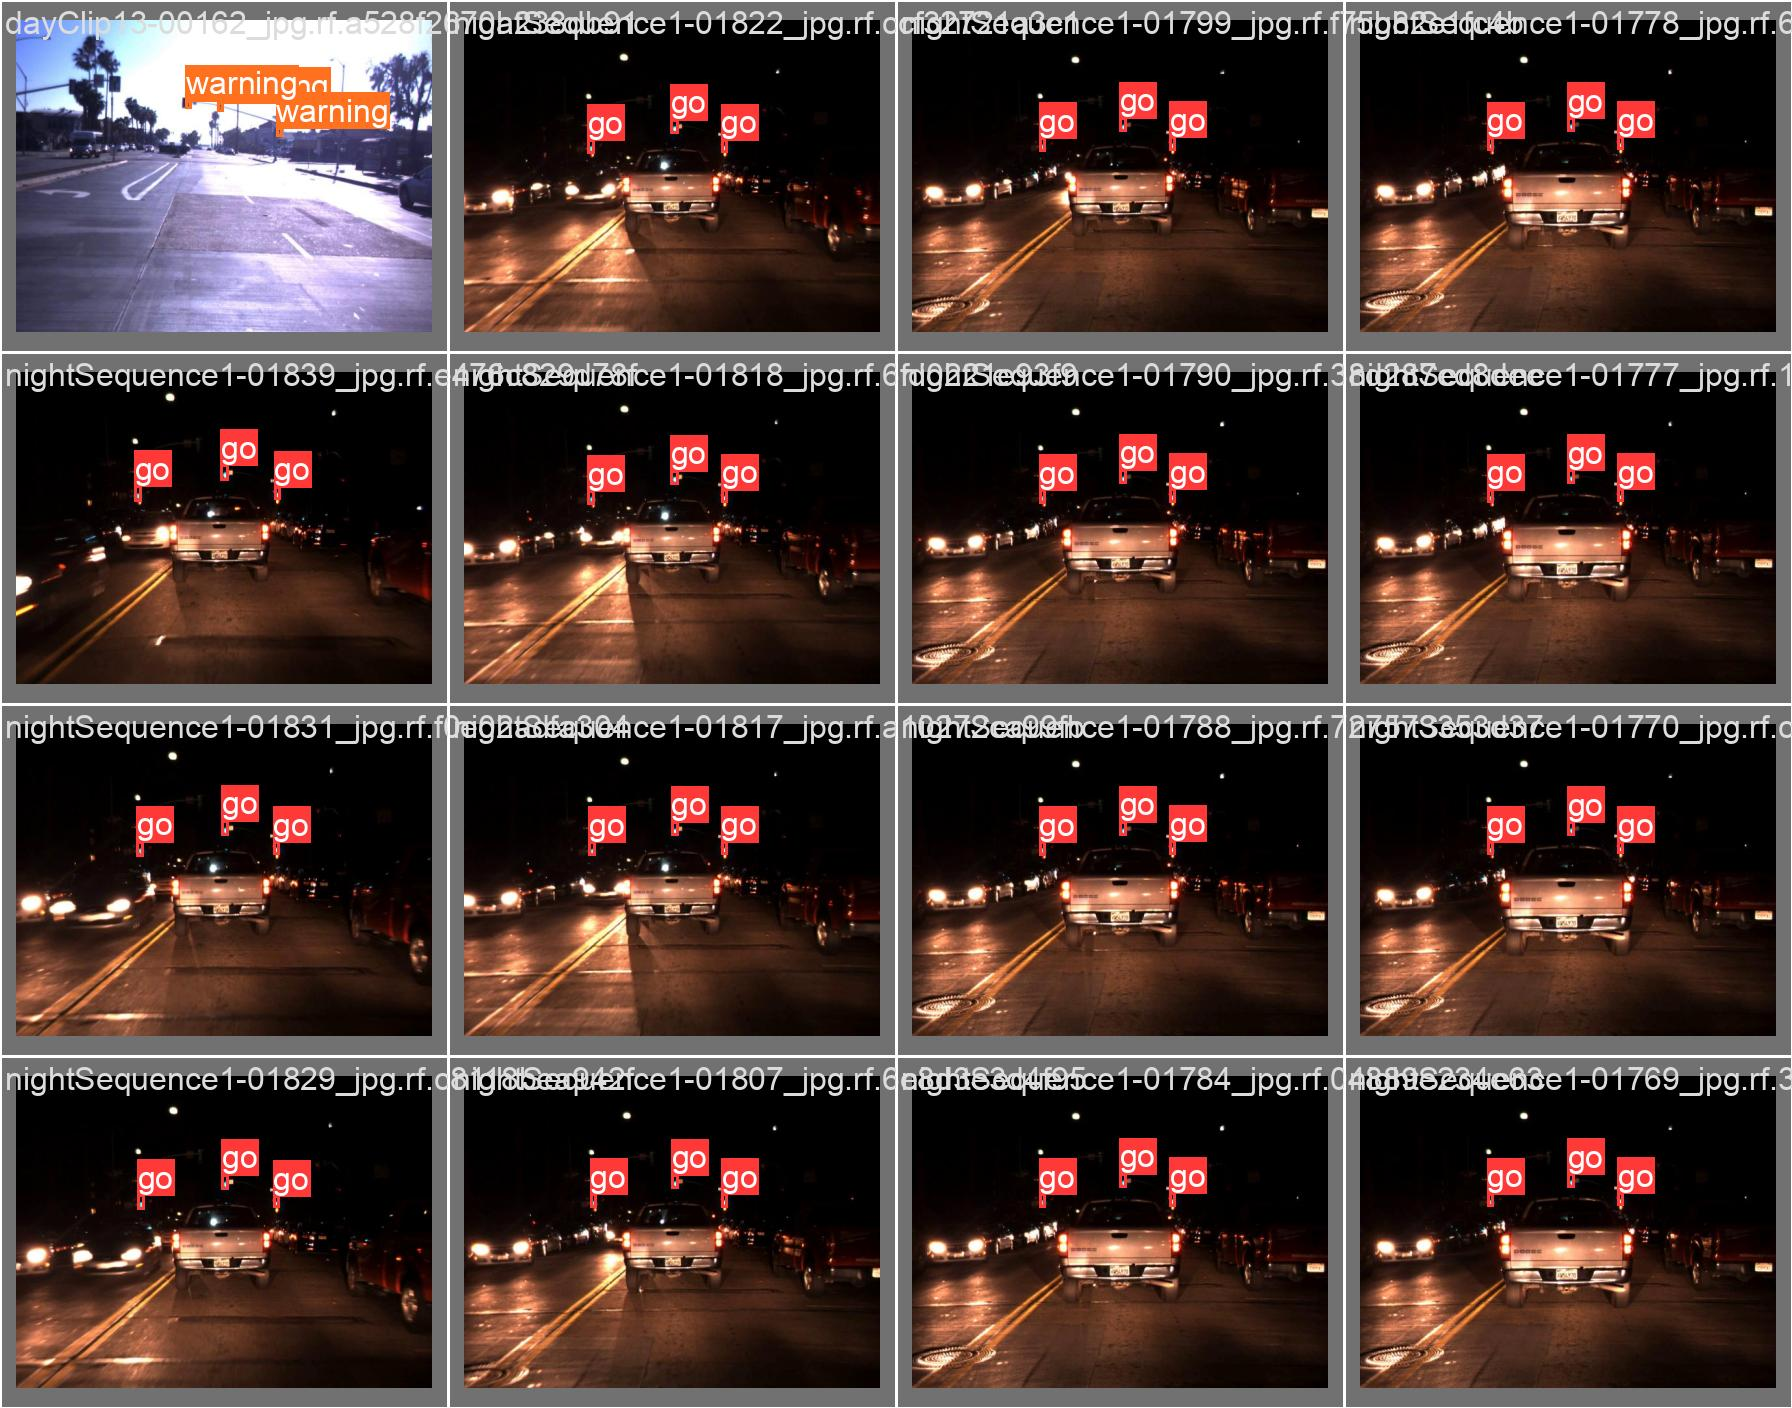

In [ ]:
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)


GROUND TRUTH AUGMENTED TRAINING DATA:


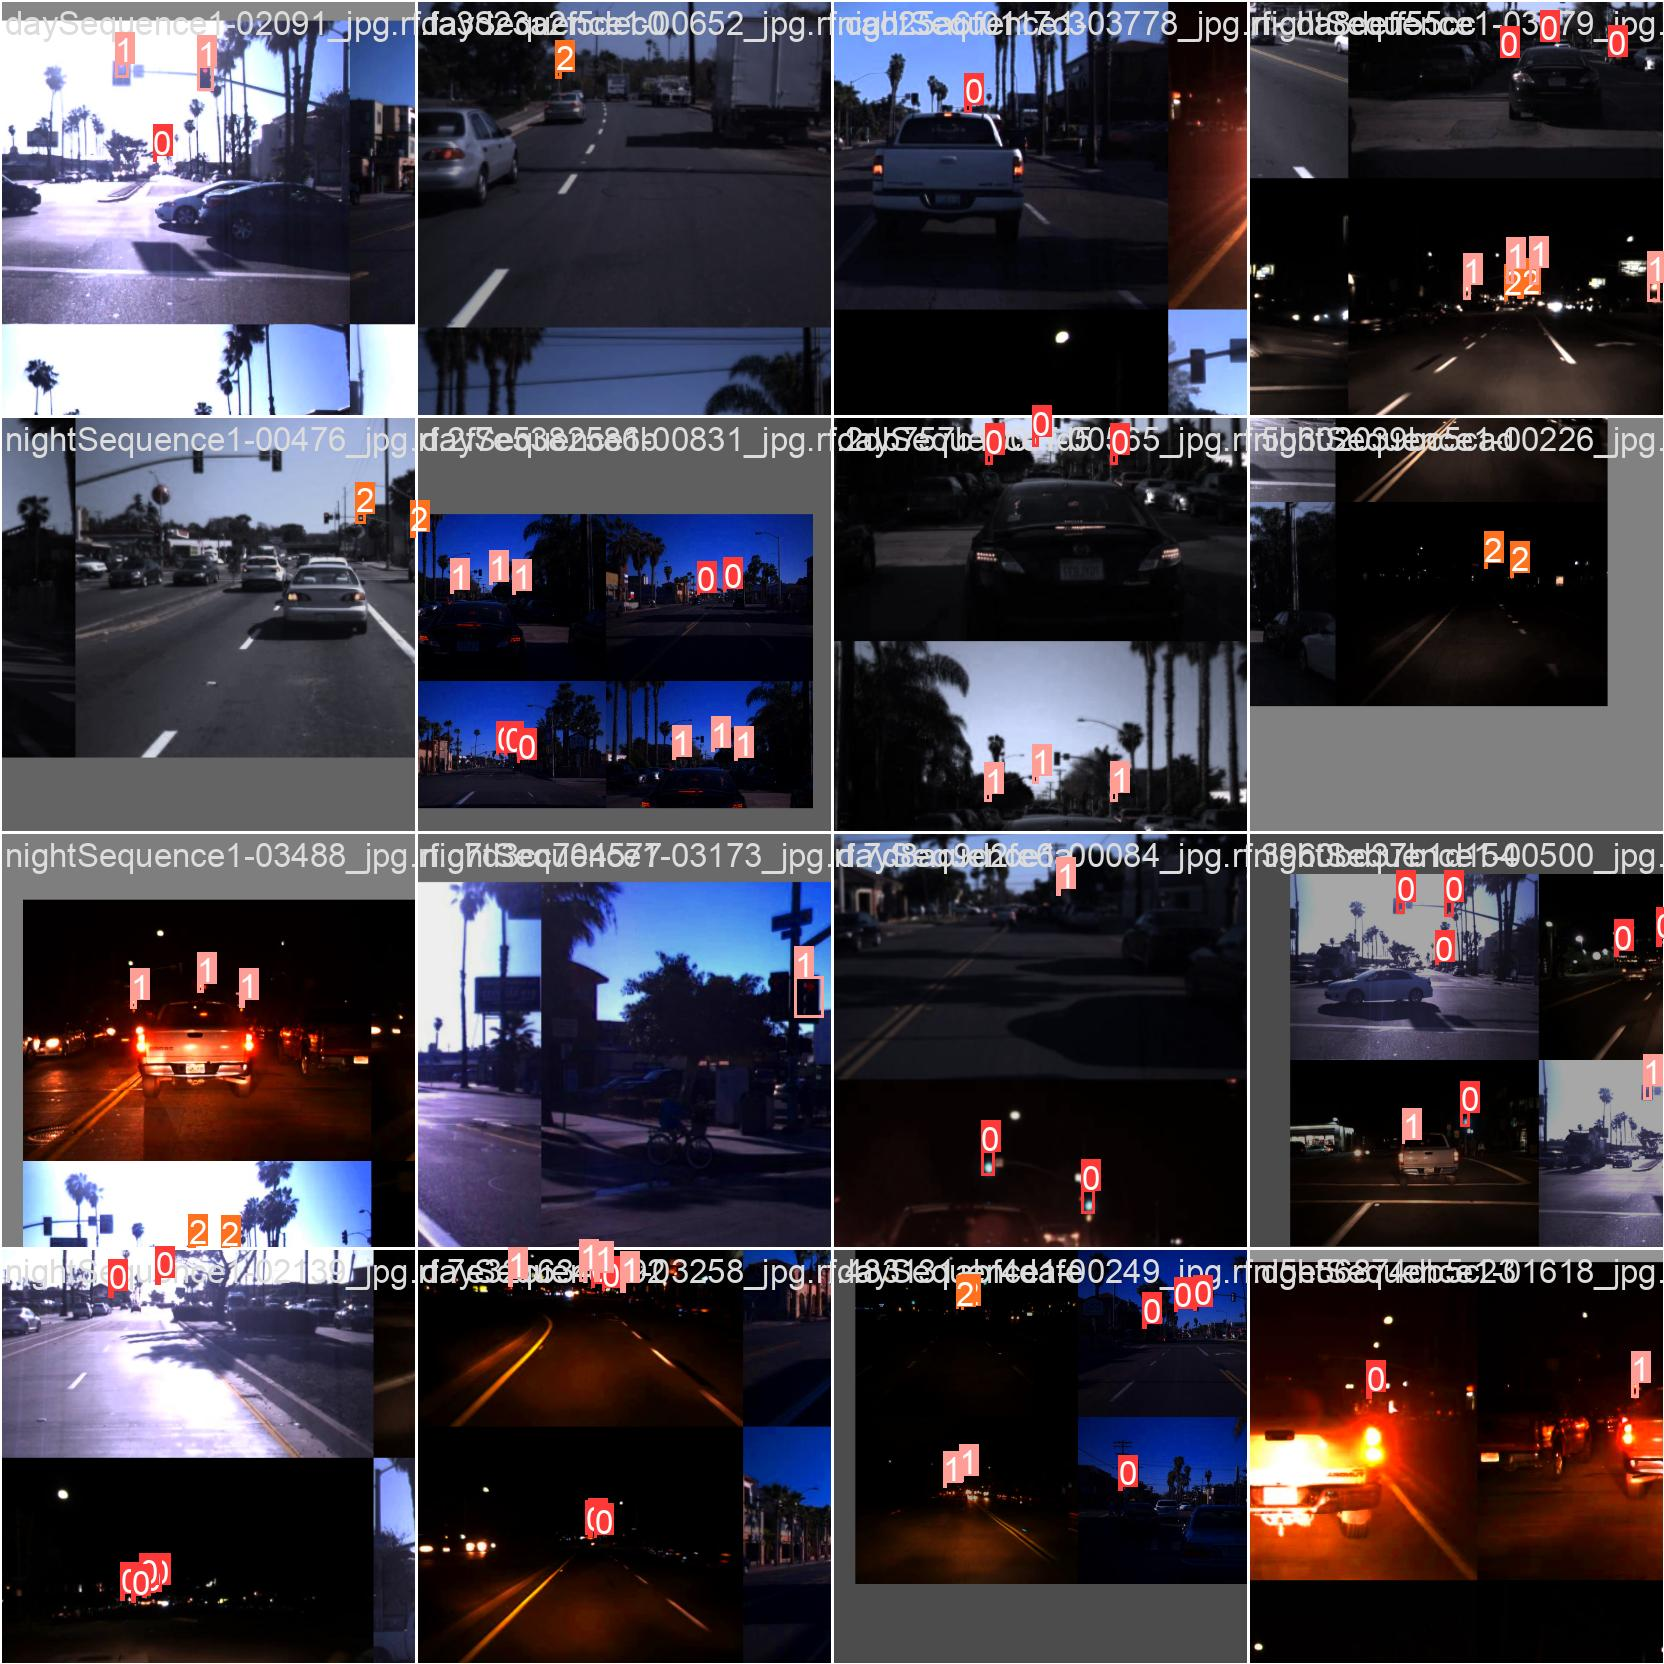

In [ ]:
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

In [ ]:
%ls runs/train/yolov5s_results/weights


best.pt  last.pt


In [ ]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source LISA-traffic-light-detection-3/test/images/


/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=LISA-traffic-light-detection-3/test/images/, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-247-g3f02fde Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7251912 parameters, 0 gradients
image 1/900 /content/yolov5/LISA-traffic-light-detection-3/test/images/dayClip13-00164_jpg.rf.cf967c375d5916edf77906dcdbcf18f4.jpg: 320x416 3 warnings, 44.1ms
image 2/900 /content/yolov5/LISA-traffic-light-detection-3/test/images/dayClip13-00175_jpg.rf.85b9bd5243546f94bcbd44a65d1761

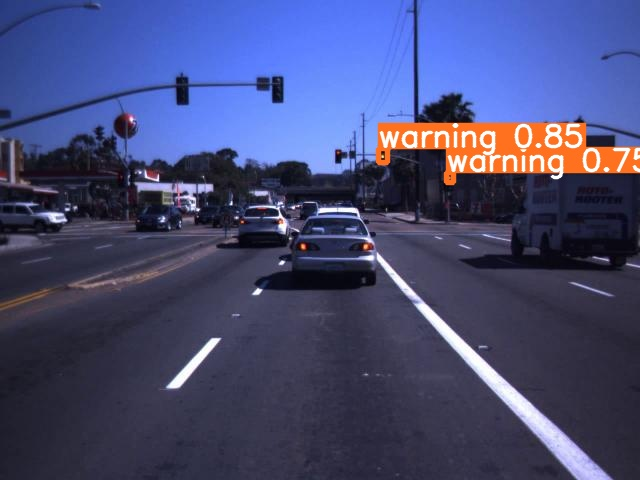

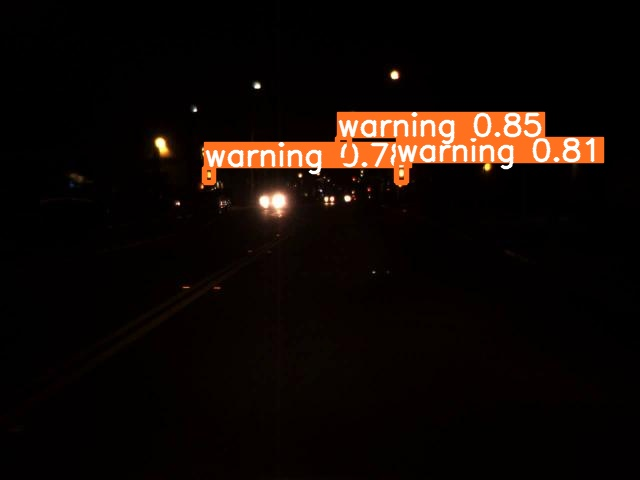

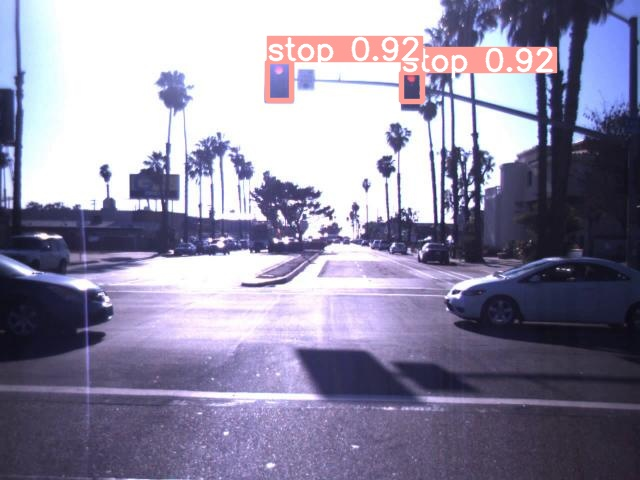

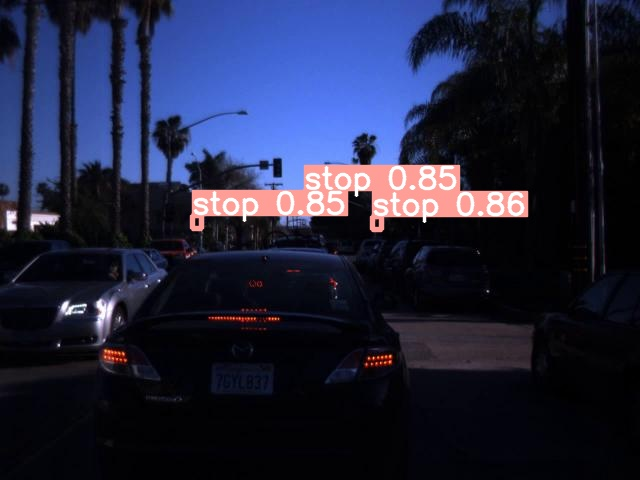

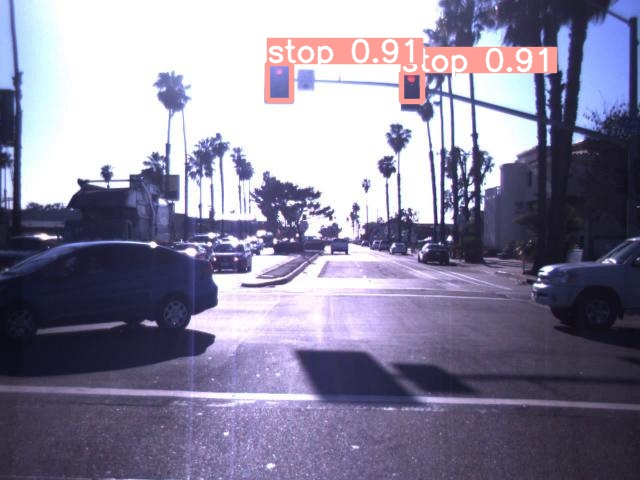

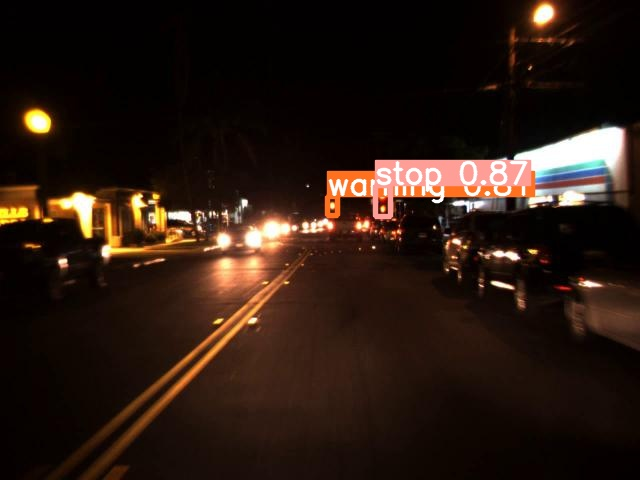

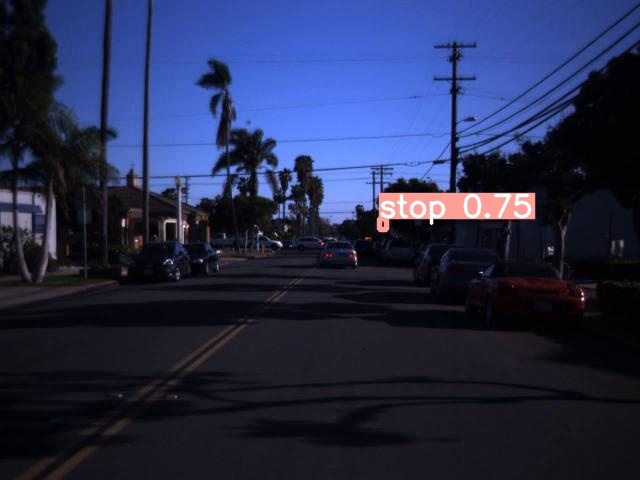

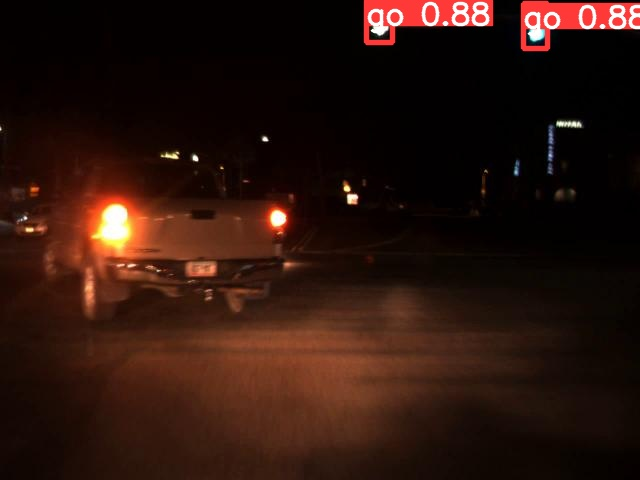

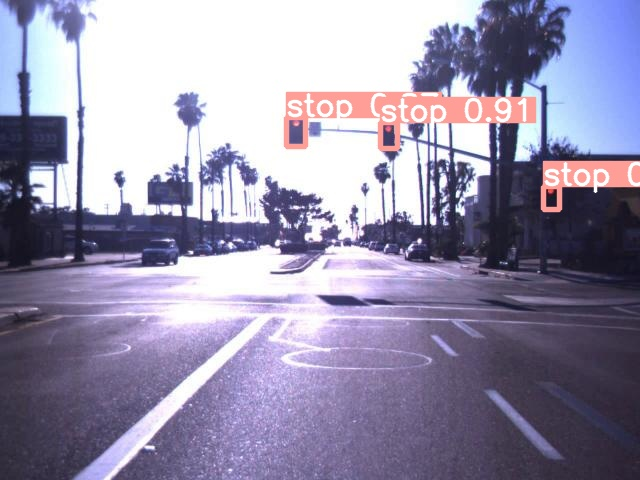

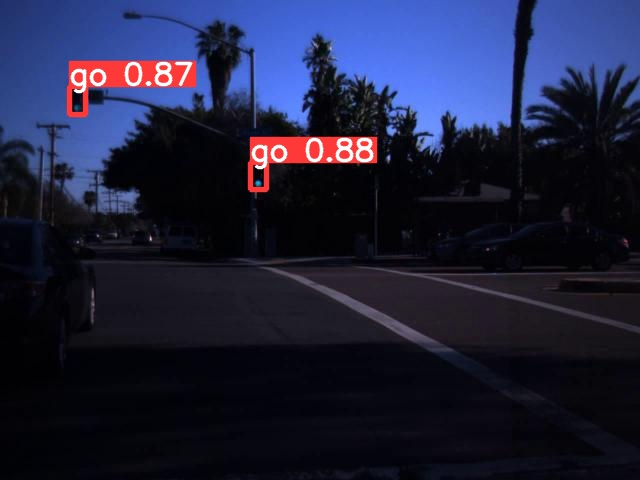

In [ ]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp2/*.jpg')[:10]: #assuming JPG
    display(Image(filename=imageName))


In [ ]:
!python val.py --weights runs/train/yolov5s_results/weights/best.pt --data {dataset.location}/data.yaml --img 640
# !!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source LISA-traffic-light-detection-3/test/images/


val: data=/content/yolov5/LISA-traffic-light-detection-3/data.yaml, weights=['runs/train/yolov5s_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-247-g3f02fde Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7251912 parameters, 0 gradients
val: Scanning /content/yolov5/LISA-traffic-light-detection-3/valid/labels.cache... 1784 images, 0 backgrounds, 0 corrupt: 100% 1784/1784 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 56/56 [00:25<00:00,  2.18it/s]
                   all       1784       5607      0.897      0.852      0.896      0.469
                    go       1784       2499   